In [3]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
%matplotlib inline

In [7]:
imgnet_dir = "/media/hdd/imagenet"
imgnet_train = join(imgnet_dir, "chunked_train")
imgnet_val = join(imgnet_dir, "chunked_val")
chunk0_data = np.memmap(join(imgnet_train,'0.data'), dtype='uint8', mode='r', shape=(6000,224,224,3))
chunk0_labels = np.memmap(join(imgnet_train,'0.labels'), dtype='int32', mode='r', shape=(6000))

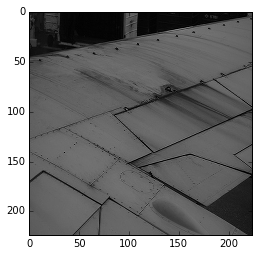

In [13]:
plt.imshow(chunk0_data[90][:,:,::-1])

In [63]:
cv2.cvtColor(cv2.cvtColor(chunk0_data[0], cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB)[0][0]


array([144, 144, 144], dtype=uint8)

In [77]:
# Let's do a few things in this notebook
# 1. Prepare a 'chunk' of humpback whale flukes
from train_utils import dataset_loc
fluke_img_dir = join(dataset_loc, "Flukes/CRC_combined constrained")
chunk_dir = join(dataset_loc, "Flukes/humpnet")

In [17]:
import glob
import random
img_list = glob.glob(join(fluke_img_dir, '*'))
random.shuffle(img_list)
train_imgs = img_list[:int(len(img_list)*0.6)]
valid_imgs = img_list[int(len(img_list)*0.6):int(len(img_list)*0.8)]
test_imgs = img_list[int(len(img_list)*0.8):]

In [40]:
filter(lambda x: x[-4:] != '.jpg', train_imgs)

['/home/zach/data/Flukes/CRC_combined constrained/ZooniverseImage2.csv',
 '/home/zach/data/Flukes/CRC_combined constrained/ZooniverseImage.csv']

In [27]:
import json
with open(join(imgnet_dir, join(imgnet_train, "listing.json")), 'r') as f:
    imgnet_chunks = json.load(f)
random_chunk = random.choice(imgnet_chunks)

In [50]:
random_chunk

{u'datafn': u'117.data',
 u'labelfn': u'117.labels',
 u'size': [6000, 224, 224, 3]}

In [30]:
def load_chunk_listing(chunkpath, listing):
    # make two memmapped arrays and load them
    chunk_data = np.memmap(join(chunkpath, listing['datafn']), shape=tuple(listing['size']), dtype=np.uint8, mode='r')
    chunk_labels = np.memmap(join(chunkpath, listing['labelfn']), shape=listing['size'][0], dtype=np.int32, mode='r')
    return chunk_data, chunk_labels
imgnet_chunk_data, imgnet_chunk_labels = load_chunk_listing(imgnet_train, random_chunk)

In [42]:
import cv2
def load_imgs(img_listing, size):
    imgs = []
    for img_fn in img_listing:
        # assume full path
        img_tmp = cv2.imread(img_fn)
        if img_tmp is None:
            continue
        #print(img_tmp.shape)
        img = cv2.resize(img_tmp, size, interpolation=cv2.INTER_LANCZOS4)
        imgs.append(img)
    return np.stack(imgs)
size = (224,224)
train_img_nd = load_imgs(train_imgs, size)        

val_img_nd = load_imgs(valid_imgs, size)
test_img_nd = load_imgs(test_imgs, size)

In [44]:
train_img_labels = np.array([1000]*train_img_nd.shape[0], dtype=np.int32)
val_img_labels = np.array([1000]*val_img_nd.shape[0], dtype=np.int32)
test_img_labels = np.array([1000]*test_img_nd.shape[0], dtype=np.int32)

In [45]:
with open(join(imgnet_dir, join(imgnet_val, "listing.json")), 'r') as f:
    imgnet_chunks_val = json.load(f)
random_chunk_val = random.choice(imgnet_chunks_val)
imgnet_chunk_data_val, imgnet_chunk_labels_val = load_chunk_listing(imgnet_val, random_chunk_val)

In [46]:
from sklearn.utils import shuffle
train_data = np.concatenate([train_img_nd, imgnet_chunk_data], axis=0)
train_labels = np.concatenate([train_img_labels, imgnet_chunk_labels], axis=0)

train_data, train_labels = shuffle(train_data, train_labels)

val_data = np.concatenate([val_img_nd, imgnet_chunk_data_val], axis=0)
val_labels = np.concatenate([val_img_labels, imgnet_chunk_labels_val], axis=0)

val_data, val_labels = shuffle(val_data, val_labels)

In [ ]:
import time
# let's do something crazy: compute imagenet mean and std
# afterwards, we'll average in the mean and std of train_img_nd
def chunk_mean_std(listing, chunkpath):
    chunk_data, chunk_labels = load_chunk_listing(chunkpath, listing)
    chunk_mean = np.average(chunk_data, axis=(0,1,2))
    chunk_std = np.std(chunk_data, axis=(0,1,2))
    del chunk_data
    del chunk_labels
    return chunk_mean, chunk_std

stds = []
means = []
for chunk_listing in imgnet_chunks:
    tic = time.time()
    this_mean, this_std = chunk_mean_std(chunk_listing, imgnet_train)
    toc = time.time() - tic
    print("Chunk %s took %0.2f seconds to calculate mean / std" % (chunk_listing['datafn'], toc))
    stds.append(this_std)
    means.append(this_mean)

Chunk 0.data took 25.49 seconds to calculate mean / std
Chunk 1.data took 26.39 seconds to calculate mean / std
Chunk 2.data took 24.97 seconds to calculate mean / std
Chunk 3.data took 25.59 seconds to calculate mean / std
Chunk 4.data took 25.05 seconds to calculate mean / std
Chunk 5.data took 27.86 seconds to calculate mean / std
Chunk 6.data took 26.55 seconds to calculate mean / std
Chunk 7.data took 25.01 seconds to calculate mean / std
Chunk 8.data took 26.41 seconds to calculate mean / std
Chunk 9.data took 25.36 seconds to calculate mean / std
Chunk 10.data took 25.06 seconds to calculate mean / std
Chunk 11.data took 31.25 seconds to calculate mean / std
Chunk 12.data took 33.58 seconds to calculate mean / std
Chunk 21.data took 19.61 seconds to calculate mean / std
Chunk 22.data took 23.19 seconds to calculate mean / std
Chunk 23.data took 24.04 seconds to calculate mean / std
Chunk 24.data took 25.56 seconds to calculate mean / std
Chunk 25.data took 25.79 seconds to calcu

In [64]:
# so we can't just take the average of each std, mean because there's different size chunks (well, at least the
# last one is a different size). Thus, we need to instead weight each chunk by its size. But, before this, let's
# add in the humpback flukes mean / std
chunk_sizes = [chunk_listing['size'][0] for chunk_listing in imgnet_chunks]
chunk_sizes.append(train_img_nd.shape[0])

humpback_avg = np.average(train_img_nd, axis=(0,1,2))
humpback_std = np.std(train_img_nd, axis=(0,1,2))
means.append(humpback_avg)
stds.append(humpback_std)

avg_mean = 0
avg_std = 0
total_imgs = 0
for mean, std, size in zip(means, stds, chunk_sizes):
    avg_mean += size*mean
    avg_std += size*std
    total_imgs += size

avg_mean /= total_imgs
avg_std /= total_imgs
print(avg_mean)
print(avg_std)

[ 104.21078292  116.81056072  122.81223542]
[ 73.64755137  70.23060675  72.04492928]


In [67]:
# Let's do the same for just Imagenet
imgnet_mean = 0
imgnet_std = 0
total_imgs = 0
for mean, std, size in zip(means, stds, chunk_sizes)[:-1]:
    imgnet_mean += size*mean
    imgnet_std += size*std
    total_imgs += size

imgnet_mean /= total_imgs
imgnet_std /= total_imgs

print(imgnet_mean)
print(imgnet_std)

[ 104.01226355  116.65552207  122.6781177 ]
[ 73.66619135  70.23750355  72.05766111]


In [68]:
# so now let's save the imgnet mean and std
import cPickle as pickle
with open(join(imgnet_train, "mean_std.pkl"), 'w') as f:
    pickle.dump({'mean':imgnet_mean, 'std':imgnet_std}, f)

In [ ]:
# One thing I realized is that most of the humpback images are grayscale, whereas most of the imagenet images
# are in full color. It is very likely that the model will simply fall into learning to mark grayscale images
# as most likely humpback, and color as anything else. Thus, I'll greyscale all of the images in the training
# data prior to z-scoring.
def greyscale_batch(batch_data):
    greyscaled_batch = []
    for i in range(batch_data.shape[0]):
        # assume BGR
        greyscaled_img = cv2.cvtColor(cv2.cvtColor(batch_data[i], cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB)
        greyscaled_batch.append(greyscaled_img)
    return np.stack(greyscaled_batch)
train_grey = greyscale_batch(train_data)
val_grey = greyscale_batch(val_data)

In [72]:
# now let's use the avg_mean and avg_std to z-score the training data
train_grey_zs = (train_grey - avg_mean) / (avg_std)
val_grey_zs = (val_grey - avg_mean) / (avg_std)

In [74]:
# oops let's not forget the test set! since the imgnet test set doesn't contain labels, I thought it'd be
# interesting to (instead of taking another chunk out of validation) use the test split of humpbacks _only_
test_grey = greyscale_batch(test_img_nd)
test_grey_zs = (test_grey - avg_mean) / (avg_std)

In [82]:
test_labels = np.array([1000]*test_grey.shape[0],dtype=np.int32)

In [84]:
%load_ext autoreload
%autoreload 2
from train_utils import save_dataset

save_dataset(chunk_dir, (train_grey, train_labels), 
             (val_grey, val_labels), 
             (test_grey, test_labels),
             norms=(avg_mean, avg_std))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Took 196.53 seconds


In [85]:
train_grey.shape

(10358, 224, 224, 3)

In [9]:
# 2. Load up vgg16, and do some surgery to to make a new network with the humpback whale fluke class added

371